In [1]:
#NUTS Figures
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Random
using Distances
using Flux
using StatsBase
using MultivariateStats

In [2]:
function sample_momenta(n::Int)
    Float64[random(normal, 0, 1) for _=1:n]
end

function assess_momenta(momenta)
    logprob = 0.
    for val in momenta
        logprob += Gen.logpdf(normal, val, 0, 1)
    end
    logprob
end

"""
    (new_trace, accepted) = hmc(
        trace, selection::Selection; L=10, eps=0.1,
        check=false, observations=EmptyChoiceMap())

Apply a Hamiltonian Monte Carlo (HMC) update that proposes new values for the selected addresses, returning the new trace (which is equal to the previous trace if the move was not accepted) and a `Bool` indicating whether the move was accepted or not.

Hamilton's equations are numerically integrated using leapfrog integration with step size `eps` for `L` steps. See equations (5.18)-(5.20) of Neal (2011).

# References
Neal, Radford M. (2011), "MCMC Using Hamiltonian Dynamics", Handbook of Markov Chain Monte Carlo, pp. 113-162. URL: http://www.mcmchandbook.net/HandbookChapter5.pdf
"""
function hmc(trace, selection, L, eps, observations)
    prev_model_score = get_score(trace)
    args = get_args(trace)
    retval_grad = accepts_output_grad(get_gen_fn(trace)) ? zero(get_retval(trace)) : nothing
    argdiffs = map((_) -> NoChange(), args)

    # run leapfrog dynamics
    new_trace = trace
    (_, values_trie, gradient_trie) = choice_gradients(new_trace, selection, retval_grad)
    values = to_array(values_trie, Float64)
    gradient = to_array(gradient_trie, Float64)
    momenta = sample_momenta(length(values))
    prev_momenta_score = assess_momenta(momenta)
    for step=1:L

        # half step on momenta
        momenta += (eps / 2) * gradient

        # full step on positions
        values += eps * momenta

        # get new gradient
        values_trie = from_array(values_trie, values)
        (new_trace, _, _) = update(new_trace, args, argdiffs, values_trie)
        (_, _, gradient_trie) = choice_gradients(new_trace, selection, retval_grad)
        gradient = to_array(gradient_trie, Float64)

        # half step on momenta
        momenta += (eps / 2) * gradient
    end

    # assess new model score (negative potential energy)
    new_model_score = get_score(new_trace)

    # assess new momenta score (negative kinetic energy)
    new_momenta_score = assess_momenta(-momenta)

    # accept or reject
    alpha = new_model_score - prev_model_score + new_momenta_score - prev_momenta_score

    (new_trace, alpha)

end;

2×2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0

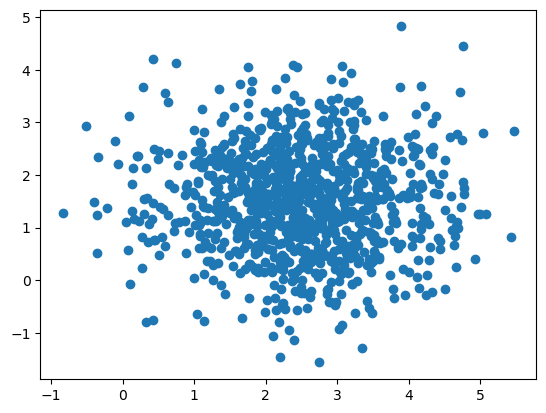

PyObject <matplotlib.collections.PathCollection object at 0x7fa4b0103550>

In [3]:
#Data
n = 1000
μ = [2.5,1.5]
Σ = [1.0 0.0
    0.0 1.0]
display(Σ)
x = rand(MvNormal(μ,Σ),n)
scatter(x[1,:],x[2,:])

In [187]:
#Gen Model

obs_master = choicemap()::ChoiceMap
for i=1:n
    obs_master[(:x,i)] = x[:,i]
end
obs = obs_master;

@gen function simple_gaussian()
    Σ = Diagonal([1 for i=1:2])
    μ = @trace(mvnormal(vec([0,0]),Σ),(:μ))
    
    #Regression Likelihood
    Σ = Diagonal([1 for i=1:2])
    x = zeros(2,n)
    for i=1:n
        x[:,i] = @trace(mvnormal(μ, Σ), (:x,i))
    end
end;

param_selection = select()
push!(param_selection,:μ)

obs_starter = obs
obs_starter[:μ] = [0.52,0.78]

(trace,) = generate(simple_gaussian,(),obs)
println(trace[:μ])

eps = 0.01

(new_trace1, alpha) = hmc(trace,param_selection,2,eps,obs)
(new_trace2, alpha) = hmc(new_trace1,param_selection,4,eps,obs)
(new_trace3, alpha) = hmc(new_trace2,param_selection,8,eps,obs)
(new_trace4, alpha) = hmc(new_trace3,param_selection,32,eps,obs)
(new_trace5, alpha) = hmc(new_trace4,param_selection,16,eps,obs);

[0.52, 0.78]


In [188]:
println(trace[:μ])
println(get_score(trace))
println(new_trace1[:μ])
println(get_score(new_trace1))
println(new_trace2[:μ])
println(get_score(new_trace2))
println(new_trace3[:μ])
println(get_score(new_trace3))
println(new_trace4[:μ])
println(get_score(new_trace4))
println(new_trace5[:μ])
println(get_score(new_trace5))

[0.52, 0.78]
-5108.169276477114
[0.8675062303030241, 0.9059587311670823]
-4393.350738149367
[2.002115399892893, 1.280397320137444]
-3019.772100454814
[2.9215874135798656, 1.717600117461791]
-2972.6428681423067
[2.2365836099632936, 1.3741027430568429]
-2911.596261293741
[2.475176429256772, 1.5178965535963327]
-2865.8516944381377


In [201]:
μ0 = round.(trace[:μ],digits=1)
μ1 = round.(new_trace1[:μ],digits=1)
μ2 = round.(new_trace2[:μ],digits=1)
μ3 = round.(new_trace3[:μ],digits=1)
μ4 = round.(new_trace4[:μ],digits=1)
μ5 = round.(new_trace5[:μ],digits=1)

score0 = round(get_score(trace),digits=2)
score1 = round(get_score(new_trace1),digits=2)
score2 = round(get_score(new_trace2),digits=2)
score3 = round(get_score(new_trace3),digits=2)
score4 = round(get_score(new_trace4),digits=2)
score5 = round(get_score(new_trace5),digits=2)

-2865.85

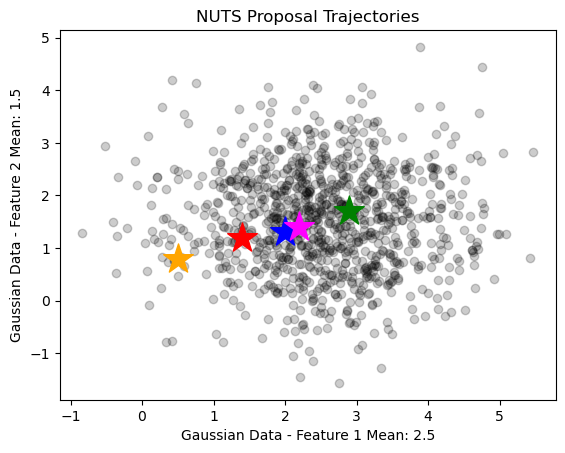

In [203]:
scatter(x[1,:],x[2,:],color="black",alpha=0.2)
scatter(μ0[1],μ0[2],s=500,color="orange",marker="*")
scatter(μ1[1],μ1[2],s=500,color="red",marker="*")
scatter(μ2[1],μ2[2],s=500,color="blue",marker="*")
scatter(μ3[1],μ3[2],s=500,color="green",marker="*")
scatter(μ4[1],μ4[2],s=500,color="magenta",marker="*")
#scatter(μ5[1],μ5[2],s=500,color="pink",marker="*")
plt.title("NUTS Proposal Trajectories")
plt.xlabel("Gaussian Data - Feature 1 Mean: 2.5")
plt.ylabel("Gaussian Data - Feature 2 Mean: 1.5");

In [205]:
printstyled("★"; color = :yellow,bold=true)
println("θ[S]:μ = $μ0") 
println("log posterior score: $score0")
printstyled("★"; color = :red,bold=true)
println("θ[1]:μ = $μ1")
println("log posterior score: $score1")
printstyled("★"; color = :blue,bold=true)
println("θ[2]:μ = $μ2") 
println("log posterior score: $score2")
printstyled("★"; color = :green,bold=true)
println("θ[3]:μ = $μ3")
println("log posterior score: $score3")
printstyled("★"; color = :magenta,bold=true)
println("θ[4]:μ = $μ4")
println("log posterior score: $score4")

★θ[S]:μ = [0.5, 0.8]
log posterior score: -5108.17
★θ[1]:μ = [1.4, 1.2]
log posterior score: -4393.35
★θ[2]:μ = [2.0, 1.3]
log posterior score: -3019.77
★θ[3]:μ = [2.9, 1.7]
log posterior score: -2972.64
★θ[4]:μ = [2.2, 1.4]
log posterior score: -2911.6
